<a href="https://colab.research.google.com/github/yskmt2018/quantum/blob/master/graph_coloring_problem_sqa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Coloring Problem with Simulated Quantum Annealing

* This notebook was created and tested on Google Colaboratory. (2020/09)

## Reference

> https://github.com/recruit-communications/pyqubo/blob/master/notebooks/japanese/graph_coloring.ipynb

In [1]:
!python -V
!pip install --quiet pyqubo openjij

Python 3.6.9


In [2]:
%matplotlib inline
import random
import pyqubo
import networkx as nx
import matplotlib.pyplot as plt
from openjij import SQASampler

## Problem Settings

* グラフ$G=(V,E)$と色数$K$が与えられたとき、グラフの頂点を$K$色で塗り分ける（彩色する）。

* このとき、隣接する頂点（すなわち、辺で接続されている頂点）は同色にならないという制約下での彩色方法を見つけたい。

In [3]:
def plot_graph(N, E, colors=None):
  G = nx.Graph()
  G.add_nodes_from([n for n in range(N)])
  for (i, j) in E:
    G.add_edge(i, j)
  plt.figure(figsize=(10,10))
  pos = nx.circular_layout(G)
  colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf']
  if colors:
    nx.draw_networkx(G, pos, node_color=[colorlist[colors[node]] for node in G.nodes], node_size=400, font_weight='bold', font_color='w')
  else:
    nx.draw_networkx(G, pos, node_color=[colorlist[0] for _ in G.nodes], node_size=400, font_weight='bold', font_color='w')
  plt.axis('off')
  plt.show()

In [4]:
def random_edge(edge_number):
  E = set()
  while len(E) < edge_number:
    f = random.randrange(0, V)
    t = random.randrange(0, V)
    if f != t:
      E.add((f, t))
  
  return E

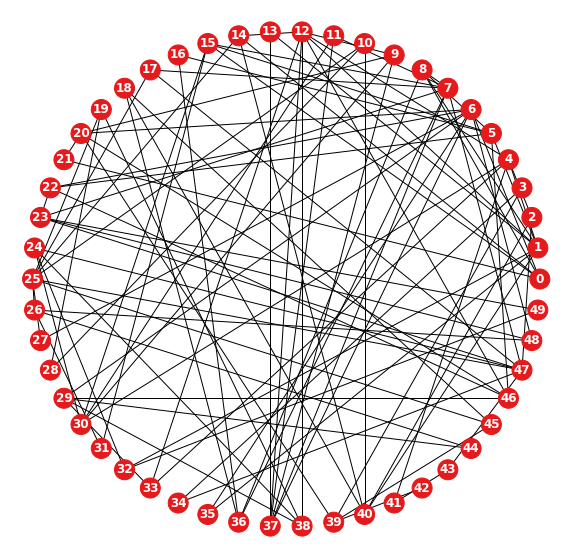

In [5]:
# Vertex Number
V = 50
# Color Number
K = 4
# Edge
E = random_edge(100)

plot_graph(V, E)

## Formulation

* GCP の制約条件を定式化し、QUBO（Quadratic Unconstrained Binary Optimization）式を構築する。

* QUBO 式の構築には、OSS ライブラリ PyQUBO（[GitHub](https://github.com/recruit-communications/pyqubo), [Documentation](https://pyqubo.readthedocs.io/en/latest/)）を用いる。

### QUBO1: Onecolor rule

* 制約条件：1つの頂点はただ1色に対応する。

$$
w_0\sum_{v \in V}\left(1 - \sum_{k = 1}^{K} x_{v,k}\right)^2
$$

In [6]:
def build_onecolor_rule(x):
  H = 0.0
  for v in range(V):
    H += pyqubo.Constraint((pyqubo.Sum(0, K, lambda k: x[v,k]) - 1)**2,
                           'onecolor{}'.format(v))
  return H

### QUBO2: Adjacent rule

* 制約条件：隣接する頂点は別色に彩色される。

$$
w_1\sum_{(i, j) \in E} \sum_{k = 1}^{K} x_{i,k} x_{j,k}
$$

In [7]:
def build_adjacent_rule(x):
  H = 0.0
  for (i, j) in E:
    for k in range(K):
      H += pyqubo.Constraint(x[i,k] * x[j,k],
                             'adjacent({},{})'.format(i, j))
  return H

### Hamiltonian

* 制約条件からハミルトニアン H を以下のように定義する。

$$
H = w_0\sum_{v \in V}\left(1 - \sum_{k = 1}^{K} x_{v,k}\right)^2
+w_1\sum_{(i, j) \in E} \sum_{k = 1}^{K} x_{i,k} x_{j,k}
$$

In [8]:
# Graph Coloring
x = pyqubo.Array.create('x', shape=(V, K), vartype='BINARY')

In [9]:
H = pyqubo.Placeholder('w_0') * build_onecolor_rule(x) + \
    pyqubo.Placeholder('w_1') * build_adjacent_rule(x)

In [10]:
feed_dict = {'w_0': 1,
             'w_1': 1}

In [11]:
model = H.compile()
qubo, constant = model.to_qubo(feed_dict=feed_dict)

## Execute Quantum Annealing

* Sampler と呼ばれるモジュールを生成し、構築した QUBO 式を渡すことで、量子アニーリングを実行する。

* 結果は、Response オブジェクトとして返却される。

### OpenJij

* OpenJij（[GitHub](https://github.com/OpenJij/OpenJij), [Documentation](https://openjij.github.io/OpenJij_Documentation/build/html/), [Tutorial](https://openjij.github.io/OpenJijTutorial/build/html/ja/index.html)）

* OSS として、量子アニーリングをシミュレートする SQA（Simulated Quantum Annealing）の Python 用 API を提供している。

In [12]:
sampler = SQASampler(num_reads=10)

In [13]:
%%time
response = sampler.sample_qubo(qubo)

CPU times: user 2.55 s, sys: 936 ms, total: 3.48 s
Wall time: 2.39 s


### Take Solutions

* Response オブジェクトに格納されている量子アニーリングの結果（解）を取り出す。

In [14]:
def extract_samples(response):
  solutions = []
  energies = []
  
  for record in response.record:
    sol, num_occ = record[0], record[2]
    solution, broken, energy = model.decode_solution(dict(zip(response.variables, sol)), vartype='BINARY', feed_dict=feed_dict)
    if len(broken) == 0:
      solutions += [solution] * num_occ
      energies += [energy] * num_occ
  
  return solutions, energies

In [15]:
solutions, energies = extract_samples(response)
best_solution = solutions[energies.index(min(energies))]

### Print Graph Coloring

* 各頂点の色を取得し、彩色後のグラフを表示する。

* 先に設定した制約条件が満たされていることを確認してください。

> 1つの頂点はただ1色に対応する。
>
> 隣接する頂点は別色に彩色される。

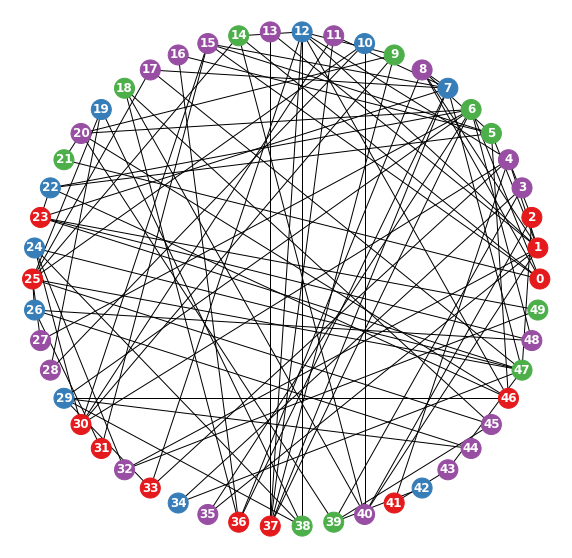

In [16]:
colors = [0 for v in range(V)]
for v in range(V):
  for k in range(K):
    if best_solution['x'][v][k] == 1:
      colors[v] = k
      break

plot_graph(V, E, colors)